### Object Grounding with Qwen3-Omni

In [1]:
import os
os.environ['VLLM_USE_V1'] = '0'
os.environ['VLLM_WORKER_MULTIPROC_METHOD'] = 'spawn'
os.environ["VLLM_LOGGING_LEVEL"] = "ERROR"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import torch
import warnings
import numpy as np

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

from qwen_omni_utils import process_mm_info
from transformers import Qwen3OmniMoeProcessor

def _load_model_processor():
    if USE_TRANSFORMERS:
        from transformers import Qwen3OmniMoeForConditionalGeneration
        if TRANSFORMERS_USE_FLASH_ATTN2:
            model = Qwen3OmniMoeForConditionalGeneration.from_pretrained(MODEL_PATH,
                                                                         dtype='auto',
                                                                         attn_implementation='flash_attention_2',
                                                                         device_map="auto")
        else:
            model = Qwen3OmniMoeForConditionalGeneration.from_pretrained(MODEL_PATH, device_map="auto", dtype='auto')
    else:
        from vllm import LLM
        model = LLM(
            model=MODEL_PATH, trust_remote_code=True, gpu_memory_utilization=0.95,
            tensor_parallel_size=torch.cuda.device_count(),
            limit_mm_per_prompt={'image': 1, 'video': 3, 'audio': 3},
            max_num_seqs=1,
            max_model_len=32768,
            seed=1234,
        )

    processor = Qwen3OmniMoeProcessor.from_pretrained(MODEL_PATH)
    return model, processor

def run_model(model, processor, messages, return_audio, use_audio_in_video):
    if USE_TRANSFORMERS:
        text = processor.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
        audios, images, videos = process_mm_info(messages, use_audio_in_video=use_audio_in_video)
        inputs = processor(text=text, audio=audios, images=images, videos=videos, return_tensors="pt", padding=True, use_audio_in_video=use_audio_in_video)
        inputs = inputs.to(model.device).to(model.dtype)
        text_ids, audio = model.generate(**inputs, 
                                            thinker_return_dict_in_generate=True,
                                            thinker_max_new_tokens=8192, 
                                            thinker_do_sample=False,
                                            speaker="Ethan", 
                                            use_audio_in_video=use_audio_in_video,
                                            return_audio=return_audio)
        response = processor.batch_decode(text_ids.sequences[:, inputs["input_ids"].shape[1] :], skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
        if audio is not None:
            audio = np.array(audio.reshape(-1).detach().cpu().numpy() * 32767).astype(np.int16)
        return response, audio
    else:
        from vllm import SamplingParams
        sampling_params = SamplingParams(temperature=1e-2, top_p=0.1, top_k=1, max_tokens=8192)
        text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        audios, images, videos = process_mm_info(messages, use_audio_in_video=use_audio_in_video)
        inputs = {'prompt': text, 'multi_modal_data': {}, "mm_processor_kwargs": {"use_audio_in_video": use_audio_in_video}}
        if images is not None: inputs['multi_modal_data']['image'] = images
        if videos is not None: inputs['multi_modal_data']['video'] = videos
        if audios is not None: inputs['multi_modal_data']['audio'] = audios
        outputs = model.generate(inputs, sampling_params=sampling_params)
        response = outputs[0].outputs[0].text
        return response, None
    

In [2]:
import librosa
import audioread

from IPython.display import Video
from IPython.display import Image
from IPython.display import Audio

MODEL_PATH = "Qwen/Qwen3-Omni-30B-A3B-Instruct"
# MODEL_PATH = "Qwen/Qwen3-Omni-30B-A3B-Thinking"

USE_TRANSFORMERS = False
TRANSFORMERS_USE_FLASH_ATTN2 = True

model, processor = _load_model_processor()

USE_AUDIO_IN_VIDEO = True
RETURN_AUDIO = False

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section', 'interleaved'}
Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section', 'interleaved'}
`torch_dtype` is deprecated! Use `dtype` instead!
2025-09-21 12:18:01,497	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
You are attempting to use Flash Attention 2 without specifying a torch dtype. This might lead to unexpected behaviour
Loading safetensors checkpoint shards:   0% Completed | 0/15 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:   7% Completed | 1/15 [00:00<00:09,  1.47it/s]
Loading safetensors checkpoint shards:  20% Completed | 3/15 [00:01<00:07,  1.64it/s]
Loading safetensors checkpoint shards:  27% Completed | 4/15 [00:03<00:09,  1.20it/s]
Loading safetensors checkpoint shards:  33% Completed | 5/15 [00:03<00:05,  1.67it/s]
Loading safetensors checkpoint shards:  40% Comp

In [3]:
import json
import requests

from PIL import Image as PIL_Image
from PIL import ImageDraw
from io import BytesIO

def extract_json_from_string(text: str) -> str:
    try:
        start_brace = text.find('{')
        start_bracket = text.find('[')
        
        if start_brace == -1:
            start_index = start_bracket
        elif start_bracket == -1:
            start_index = start_brace
        else:
            start_index = min(start_brace, start_bracket)

        end_brace = text.rfind('}')
        end_bracket = text.rfind(']')
        end_index = max(end_brace, end_bracket)

        if start_index == -1 or end_index == -1:
            return text 

        return text[start_index : end_index + 1]
    except Exception:
        return text

def draw_normalized_bounding_boxes(image_path: str, llm_output_string: str):
    if image_path.startswith(('http', 'https')):
        response = requests.get(image_path)
        img = PIL_Image.open(BytesIO(response.content))
    else:
        img = PIL_Image.open(image_path)
    
    img_width, img_height = img.size
    
    clean_json_str = extract_json_from_string(llm_output_string)

    locations = json.loads(clean_json_str)
    draw = ImageDraw.Draw(img)

    for loc in locations:
        norm_box = loc['bbox_2d']
        
        pixel_box = [
            (norm_box[0] / 1000) * img_width,
            (norm_box[1] / 1000) * img_height,
            (norm_box[2] / 1000) * img_width,
            (norm_box[3] / 1000) * img_height,
        ]
        
        draw.rectangle(pixel_box, outline='lime', width=3)

    buffer = BytesIO()
    img.save(buffer, format='PNG')
    annotated_img = buffer.getvalue()

    return annotated_img

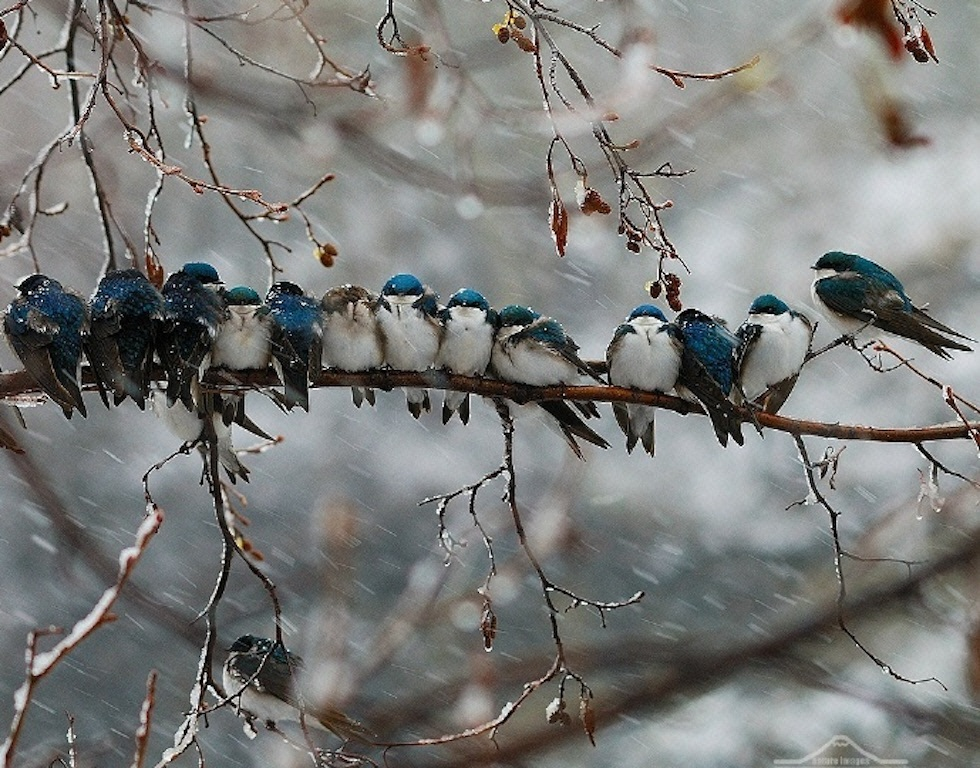

Processed prompts: 100%|██████████| 1/1 [00:03<00:00,  3.99s/it, est. speed input: 190.91 toks/s, output: 116.65 toks/s]


```json
[
	{"bbox_2d": [228, 825, 388, 967], "label": "bird"},
	{"bbox_2d": [825, 325, 999, 470], "label": "bird"},
	{"bbox_2d": [749, 382, 831, 545], "label": "bird"},
	{"bbox_2d": [688, 398, 758, 582], "label": "bird"},
	{"bbox_2d": [617, 398, 697, 592], "label": "bird"},
	{"bbox_2d": [499, 398, 624, 598], "label": "bird"},
	{"bbox_2d": [448, 377, 505, 551], "label": "bird"},
	{"bbox_2d": [385, 357, 450, 545], "label": "bird"},
	{"bbox_2d": [325, 371, 391, 531], "label": "bird"},
	{"bbox_2d": [268, 365, 325, 538], "label": "bird"},
	{"bbox_2d": [215, 371, 278, 579], "label": "bird"},
	{"bbox_2d": [165, 341, 231, 541], "label": "bird"},
	{"bbox_2d": [88, 348, 168, 535], "label": "bird"},
	{"bbox_2d": [0, 357, 92, 545], "label": "bird"}
]
```


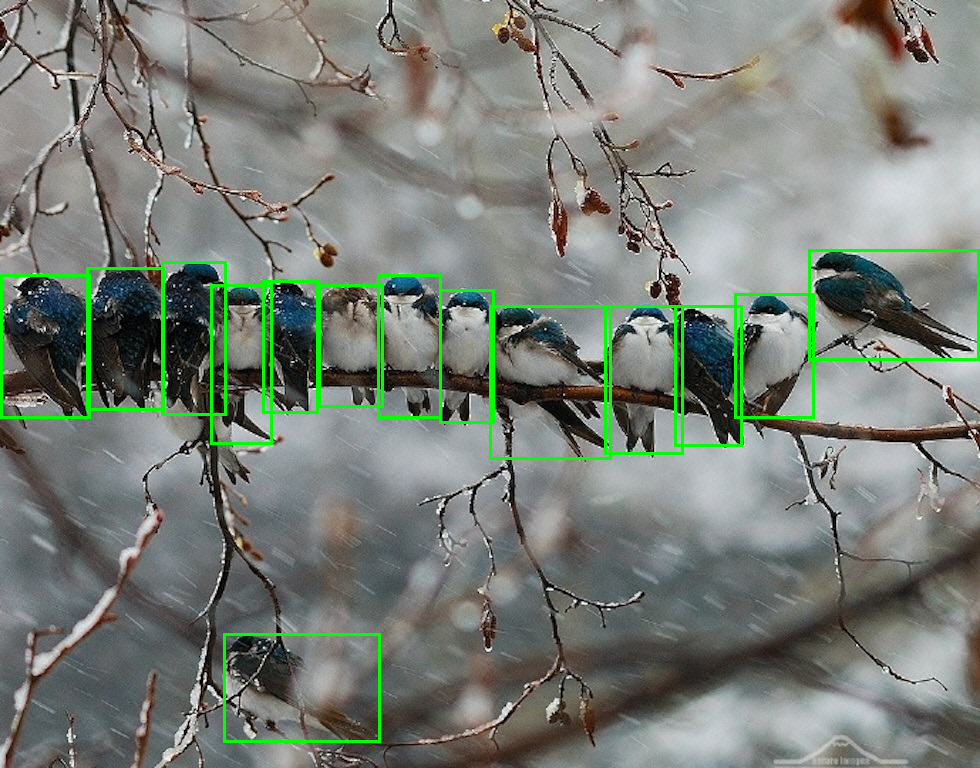

In [ ]:
image_path = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen3-Omni/cookbook/grounding1.jpeg"

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image_path},
            {"type": "text", "text": "Locate the object: bird."},
        ]
    }
]

display(Image(image_path, width=640, height=360))

response, _ = run_model(model=model, messages=messages, processor=processor, return_audio=RETURN_AUDIO, use_audio_in_video=USE_AUDIO_IN_VIDEO)

print(response)

annotated_image = draw_normalized_bounding_boxes(image_path, response)

display(Image(annotated_image, width=640, height=360))


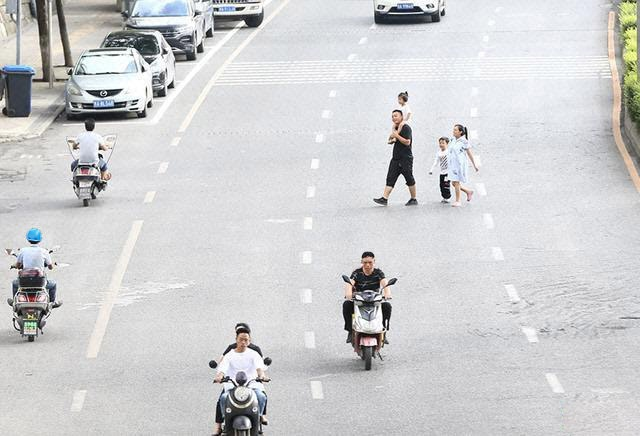

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s, est. speed input: 562.38 toks/s, output: 86.66 toks/s]


```json
[
  {"bbox_2d": [11, 519, 95, 717], "label": "A person riding a motorcycle while wearing a helmet."}
]
```


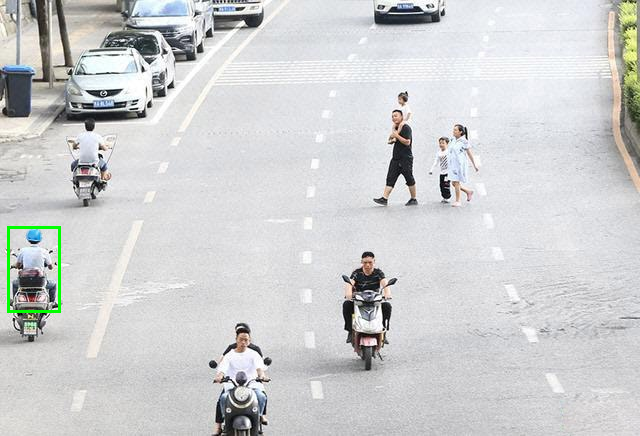

In [ ]:
image_path = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen3-Omni/cookbook/grounding2.jpg"

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image_path},
            {"type": "text", "text": "Locate the object: A person riding a motorcycle while wearing a helmet."},
        ]
    }
]

display(Image(image_path, width=640, height=360))

response, _ = run_model(model=model, messages=messages, processor=processor, return_audio=RETURN_AUDIO, use_audio_in_video=USE_AUDIO_IN_VIDEO)

print(response)

annotated_image = draw_normalized_bounding_boxes(image_path, response)

display(Image(annotated_image, width=640, height=360))